In [3]:
# Movie Genre Classification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the data
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(':::')
            if len(parts) >= 4:  # For train data (ID, Title, Genre, Description)
                data.append({
                    'id': parts[0].strip(),
                    'title': parts[1].strip(),
                    'genre': parts[2].strip(),
                    'description': parts[3].strip()
                })
            elif len(parts) == 3:  # For test data (ID, Title, Description)
                data.append({
                    'id': parts[0].strip(),
                    'title': parts[1].strip(),
                    'description': parts[2].strip()
                })
    return pd.DataFrame(data)

In [5]:
# Load train data
train_df = load_data('train_data.txt')

# Load test data and solutions (for evaluation)
test_df = load_data('test_data.txt')
test_solutions = load_data('test_data_solution.txt')

# Merge test data with solutions to get labeled test data
test_df = test_df.merge(test_solutions[['id', 'genre']], on='id', how='left')

In [6]:
# Explore the data
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nGenre distribution in training data:")
print(train_df['genre'].value_counts())

Train data shape: (54214, 4)
Test data shape: (54200, 4)

Genre distribution in training data:
genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: count, dtype: int64


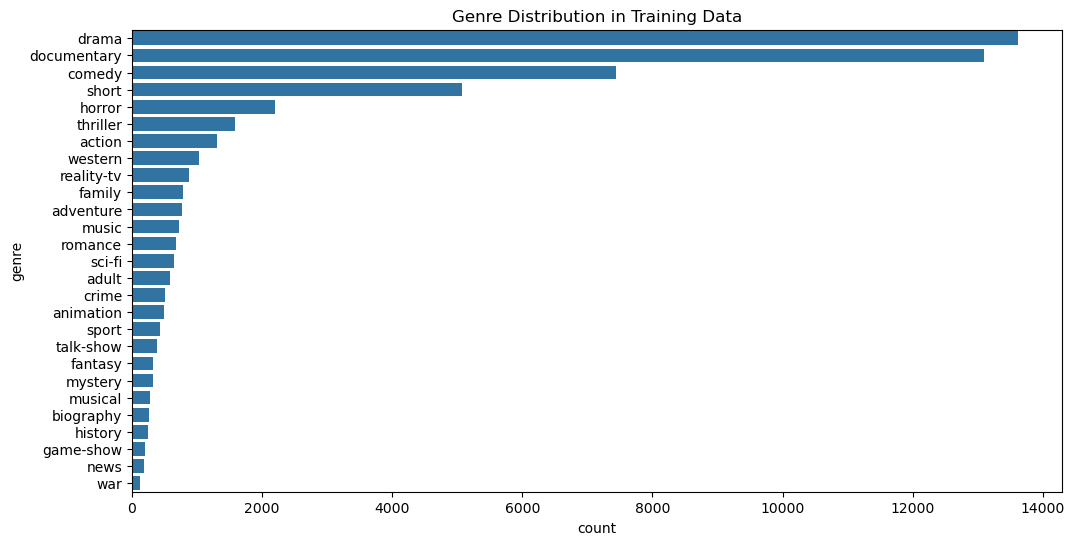

In [7]:

# Visualize genre distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='genre', data=train_df, order=train_df['genre'].value_counts().index)
plt.title('Genre Distribution in Training Data')
plt.show()

# Preprocessing
# Combine title and description for better features
train_df['text'] = train_df['title'] + ' ' + train_df['description']
test_df['text'] = test_df['title'] + ' ' + test_df['description']

# Encode genres
label_encoder = LabelEncoder()
train_df['genre_encoded'] = label_encoder.fit_transform(train_df['genre'])
test_df['genre_encoded'] = label_encoder.transform(test_df['genre'])

In [ ]:

# TRAIN-VALIDATION SPLIT AND TF-IDF VECTORIZATION


# Split into training and validation sets
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text'],        # Features (text data)
    train_df['genre_encoded'],  # Labels (encoded genres)
    test_size=0.2,          # 20% for validation
    random_state=42,        # For reproducibility
    stratify=train_df['genre_encoded']  # Maintain genre distribution
)

print("Split completed successfully!")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Total samples: {len(train_df)}")

# --------------------------------------------------
#  TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,     # Keep top 10,000 words
    stop_words='english',   # Remove common words
    ngram_range=(1, 2),     # Use 1-grams and 2-grams
    min_df=5,               # Ignore terms appearing in <5 docs
    max_df=0.7              # Ignore terms appearing in >70% docs
)

# Fit on training data and transform both sets
print("\nFitting TF-IDF vectorizer...")
X_train_tfidf = tfidf.fit_transform(X_train)  # Fit and transform train
X_val_tfidf = tfidf.transform(X_val)          # Transform validation

print("\nVectorization complete!")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Validation features shape: {X_val_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")



Split completed successfully!
Training samples: 43371
Validation samples: 10843
Total samples: 54214

Fitting TF-IDF vectorizer...


In [2]:
# MODEL TRAINING AND EVALUATION
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear SVM": LinearSVC(random_state=42, dual=False)  # Added dual=False to avoid warning
}

trained_models = {}
for name, model in models.items():
    trained_model = train_and_evaluate(model, name)
    if trained_model:
        trained_models[name] = trained_model

# MAKE PREDICTIONS
if trained_models:  # Only proceed if models were trained successfully
    sample_text = "A group of friends go camping and encounter a mysterious creature"
    
    # Get the best performing model (you can choose based on your results)
    best_model_name = max(trained_models.keys(), 
                         key=lambda x: accuracy_score(y_val, trained_models[x].predict(X_val_tfidf)))
    best_model = trained_models[best_model_name]
    
    print(f"\nUsing best model: {best_model_name}")
    
    # Transform and predict
    sample_tfidf = tfidf.transform([sample_text])
    predicted_label = best_model.predict(sample_tfidf)[0]
    predicted_genre = label_encoder.inverse_transform([predicted_label])[0]

    print(f"\nSample Prediction:")
    print(f"Text: {sample_text}")
    print(f"Predicted Genre: {predicted_genre}")
else:
    print("No models were trained successfully.")


Training Naive Bayes...

Naive Bayes Validation Performance:
              precision    recall  f1-score   support

      action       0.69      0.04      0.08       263
       adult       0.64      0.06      0.11       118
   adventure       0.89      0.05      0.10       155
   animation       0.00      0.00      0.00       100
   biography       0.00      0.00      0.00        53
      comedy       0.53      0.44      0.48      1490
       crime       0.00      0.00      0.00       101
 documentary       0.57      0.90      0.70      2619
       drama       0.46      0.83      0.59      2723
      family       0.00      0.00      0.00       157
     fantasy       0.00      0.00      0.00        65
   game-show       1.00      0.05      0.10        39
     history       0.00      0.00      0.00        49
      horror       0.79      0.31      0.44       441
       music       0.80      0.03      0.05       146
     musical       0.00      0.00      0.00        55
     mystery       